# VQA using Word2Vec, Resnet-52 and LSTM

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pprint
import re

import torch
import torchtext
from torch import nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from huggingface_hub import PyTorchModelHubMixin

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json 
from PIL import Image
from pathlib import Path
import warnings
import random
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from torch.cuda import amp
warnings.filterwarnings("ignore")

## Dataset preparation

In [2]:
imageDir = '../input/visual-based-question-answering/train2014/train2014/'
train_questions = json.load(open("../input/visual-based-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json"))['questions']
train_annotations = json.load(open("../input/visual-based-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json"))['annotations']

val_questions = json.load(open("/kaggle/input/visual-based-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json"))['questions']
val_annotaions = json.load(open("/kaggle/input/visual-based-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json"))['annotations']

In [3]:
questions_df = pd.DataFrame(train_questions)
annotations_df = pd.DataFrame(train_annotations)

questions_df_val = pd.DataFrame(val_questions)
annotations_df_val = pd.DataFrame(val_annotaions)

df_train = pd.merge(questions_df, annotations_df, on='question_id')
df_val = pd.merge(questions_df_val, annotations_df_val, on='question_id')

In [4]:
df_val

,image_id_x,question,question_id,question_type,multiple_choice_answer,answers,image_id_y,answer_type
0,262148,Where is he looking?,262148000,none of the above,down,"[{'answer': 'down', 'answer_confidence': 'yes'...",262148,other
1,262148,What are the people in the background doing?,262148001,what are the,watching,"[{'answer': 'spectating', 'answer_confidence':...",262148,other
2,262148,What is he on top of?,262148002,what is,picnic table,"[{'answer': 'table', 'answer_confidence': 'yes...",262148,other
3,393225,What website copyrighted the picture?,393225000,what,foodiebakercom,"[{'answer': 'foodiebakercom', 'answer_confiden...",393225,other
4,393225,Is this a creamy soup?,393225001,is this a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",393225,yes/no
...,...,...,...,...,...,...,...,...
214349,393212,What is the main color in the photo?,393212000,what is the,green,"[{'answer': 'green', 'answer_confidence': 'yes...",393212,other
214350,393212,What is the meaning of this sign?,393212001,what is the,go left,"[{'answer': 'one way', 'answer_confidence': 'm...",393212,other
214351,393212,What is on the sign?,393212002,what is on the,arrow,"[{'answer': 'arrow', 'answer_confidence': 'yes...",393212,other
214352,393212,Does the arrow point left or right?,393212003,does the,left,"[{'answer': 'left', 'answer_confidence': 'yes'...",393212,other


In [5]:
def modify_dataframe(df):
    df.rename(columns={"image_id_x":"image_id"}, inplace=True)
    df.drop(columns="image_id_y", axis=1, inplace=True)
    return df

df_train = modify_dataframe(df_train)
df_val = modify_dataframe(df_val)
df_val.shape

(214354, 7)

In [6]:
df_train = df_train[df_train.answer_type == 'yes/no']
df_val = df_val[df_val.answer_type == 'yes/no']
df_val, _ = train_test_split(df_val, train_size=10000)
df_val.shape
df_train.shape, df_val.shape

((166882, 7), (10000, 7))

In [7]:
df_train = df_train[df_train['multiple_choice_answer'].isin(['yes', 'no'])]
df_val = df_val[df_val['multiple_choice_answer'].isin(['yes', 'no'])]
df_train.multiple_choice_answer.value_counts(), df_val.multiple_choice_answer.value_counts()

(yes    84615
 no     82263
 Name: multiple_choice_answer, dtype: int64,
 yes    5043
 no     4956
 Name: multiple_choice_answer, dtype: int64)

In [8]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [9]:
classes = ['yes', 'no']
print("Total classes :", len(classes), "\nExample :", classes[0])

Total classes : 2 
Example : yes


## VQA data providers

In [10]:
questions = df_train.question.tolist()
tokenizer = get_tokenizer("spacy", language="en")

def built_vocabulary(questions:list, eval_question, tokenizer):
    counter = Counter()
    for _string in questions:
        counter.update(tokenizer(_string))
    for _string in eval_question:
        counter.update(tokenizer(_string))
    voca = vocab(counter, specials = ['<pad>', "<bos>", "<eos>", "<unk>"])
    
    print("-------------Vocabulary built---------------")
    return voca

en_vocabulary = built_vocabulary(questions, df_val.question.tolist(), tokenizer) 
max_features = len(en_vocabulary)
print("Total words in Question vocabulary :", max_features)
print("Total classes :", len(classes))

class VQADataset(torch.utils.data.Dataset):
    def __init__(
        self, df:pd.DataFrame, questions:list, vocab:vocab, classes = classes, 
        image_dir:Path = Path("/kaggle/input/visual-based-question-answering/train2014/train2014"),
        mode:str = 'train'
        ) -> None:
        super().__init__()
        self.df = df
        tokenized_questions = []
        self.vocab = vocab
        for ques in questions:
            tokenized_questions.append([self.vocab[token] for token in tokenizer(self.clean_text(ques))])
        self.tokenized_questions = tokenized_questions
        self.img_directory = image_dir
#         self.le = LabelEncoder()
#         self.le.fit(df.answer)
        self.classes = classes
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                     std=[0.229, 0.224, 0.225])
        ])
        
        self.num_classes = len(classes)
        self.image_dir = Path(image_dir)
        if mode == "train":
            self.base_path = Path("COCO_train2014_")
        else:
            self.base_path = Path("COCO_val2014_")

    def __len__(self):
        return len(self.df)

    def clean_text(self, x):
        pattern = r'[^a-zA-z0-9\s]'
        text = re.sub(pattern, '', x)
        text = replace_contractions(text)
        return text.lower()

    def form_path(self, img_id):      
        img_id = str(img_id)
        img_id = "0" * (12 - len(img_id)) + img_id

        return Path(str(self.base_path) + img_id + ".jpg")
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        question = torch.tensor(self.tokenized_questions[idx], dtype=torch.long)
        image_path = self.image_dir / self.form_path(row['image_id'])
        
        if image_path.exists():
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)

        answer = self.classes.index(self.df.multiple_choice_answer.iloc[idx])
        return question, image, answer

BOS_IDX = en_vocabulary["<bos>"]
EOS_IDX = en_vocabulary["<eos>"]
PAD_IDX = en_vocabulary["<pad>"]
UNK_IDX = en_vocabulary["<unk>"]

en_vocabulary.set_default_index(UNK_IDX)
print("Default index set as {}".format(UNK_IDX))

def data_collator(batch):
    questions, images, answers = zip(*batch)
    ques_batch = []
    for ques in questions:
        ques_batch.append(torch.cat([torch.tensor([BOS_IDX]), ques, torch.tensor([EOS_IDX])], dim=0))
    ques_batch = pad_sequence(ques_batch, batch_first=True, padding_value=PAD_IDX)
    images = torch.stack(images, dim=0)
    answers = torch.tensor(answers, dtype=torch.long)
    return {
        "Questions": ques_batch,
        "images": images, 
        "Labels": answers
    }

train_dataset = VQADataset(df_train, questions, en_vocabulary)
eval_dataset = VQADataset(df_val, df_val.question.tolist(), en_vocabulary, image_dir='/kaggle/input/visual-based-question-answering/val2014/val2014', mode='val')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)

print(f"\nNumber of training examples : {len(train_dataset)}")
print(f"Number of validation examples : {len(eval_dataset)}")

-------------Vocabulary built---------------
Total words in Question vocabulary : 11399
Total classes : 2
Default index set as 3

Number of training examples : 166878
Number of validation examples : 9999


In [11]:
for batch in eval_loader:
    break
{k:v.shape for k, v in batch.items()}    

{'Questions': torch.Size([16, 10]),
 'images': torch.Size([16, 3, 224, 224]),
 'Labels': torch.Size([16])}

## Word2Vec

In [12]:
import gensim.models.keyedvectors as word2vec
word2vec = word2vec.KeyedVectors.load_word2vec_format('/kaggle/input/google-word2vec/GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = word2vec.vectors
print("Shape of the embedding matrix :", embedding_matrix.shape)

Shape of the embedding matrix : (3000000, 300)


In [13]:
max_features 

11399

In [14]:
embed_matrix = np.zeros((max_features, 300))
c = 0
for word, i in en_vocabulary.get_stoi().items():
    try:
        embed_matrix[i] = word2vec[word]
    except:
        c += 1
        pass
embed_matrix.shape, c

((11399, 300), 215)

## Model

In [15]:
import torch

class TextModel(nn.Module, PyTorchModelHubMixin):
    def  __init__(self ,  hidden_size ,  embedding_size ,  vocab_size ,  num_layers ,  dropout ,  bidirectional ,  pretrained_embedding = None ):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        if pretrained_embedding is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embedding))
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, dropout=self.dropout, bidirectional=self.bidirectional)
        self.dropout = nn.Dropout(self.dropout)

    def forward(self , _input):
#         print(f"Text Input shape:{_input.shape}")
        hidden = self.init_hidden(_input.size(1))
        embedded = self.dropout(self.embedding(_input))
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self , batch_size):
        if self.bidirectional:
            return (torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device))
        else:
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

class ImageModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
#          = torch.nn.Sequential(*(list(model.children())[:-1]))
#         print(list(self.resnet.children())[-1])
        self.resnet.fc = nn.Linear(2048, 512)
        self.dropout = nn.Dropout(0.5)

    def forward(self, _input):
#         print(f"Image Input shape:{_input.shape}")
        x = self.resnet(_input)
#         print(x.shape)
        x = self.dropout(x)
        return x

class Model(nn.Module, PyTorchModelHubMixin):
    def __init__(self, image_model, text_model, num_classes, multimodal_hidden_size=512):
        super().__init__()
        self.image_model = image_model
        self.text_model = text_model
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, multimodal_hidden_size)
        self.hidden3 = nn.Linear(multimodal_hidden_size,  num_classes)

    def forward(self, x):
        if not isinstance(x, dict):
            print("Not a dictionary")
        img_features = self.image_model(x['images'])
        _, text_features = self.text_model(x['Questions'].permute((-1, 0)))
#         print(text_features[0][0, :, :].shape, img_features.shape)
        z = torch.mul(img_features, text_features[0][0, :, :])
        z = self.hidden1(z)
        z = self.hidden2(z)
        z = self.hidden3(z)
        return z

In [16]:
num_classes = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_model = TextModel(
    hidden_size = 512, 
    embedding_size = 300, 
    vocab_size = len(en_vocabulary), 
    num_layers = 2, 
    dropout = 0.5, 
    bidirectional = False, 
    pretrained_embedding = embed_matrix
) 
image_model = ImageModel()
model = Model(image_model, text_model, num_classes=1) 

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

## TRAINING

In [17]:
def prepare_data(batch_size):
    train_dataset = VQADataset(df_train, questions, en_vocabulary)
    eval_dataset = VQADataset(df_val, df_val.question.tolist(), en_vocabulary, image_dir='/kaggle/input/visual-based-question-answering/val2014/val2014', mode='val')

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
    return train_loader, eval_loader

In [18]:
# # from tqdm.auto import tqdm
# from sklearn.metrics import accuracy_score
# from torch.cuda import amp

# def train():
#     accum_iter = 2
#     num_epochs = 10
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model.to(device)
#     scaler = amp.GradScaler()
#     best_loss = 1000000000
# #     wandb.watch(model, criterion, log="all")
    
#     train_loader, eval_loader = prepare_data(32)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)
    
#     for i in tqdm(range(num_epochs)):
#         model.train()
#         train_epoch_loss = []
#         train_epoch_acc = []
#         avg_train_loss = 0
#         avg_train_acc = 0
#         with tqdm(train_loader, unit="batch", leave=True, position=0) as pbar:
#             for batch_idx, batch in enumerate(pbar):
                
#                 batch = {k:v.to(device) for k, v in batch.items()}

#                 with amp.autocast(dtype=torch.float32):
#                     output = model(batch)
#                     loss = criterion(output, batch['Labels'].float().unsqueeze(-1))
#                     loss = loss / accum_iter 
                
#                 scaler.scale(loss).backward()

#                 if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
#                     scaler.step(optimizer)
#                     scaler.update()
#                     optimizer.zero_grad()
#                     scheduler.step()

#                     avg_train_loss += loss.item()/len(train_loader)
#                     predictions = torch.argmax(output, axis=-1)
# #                     print(output.detach().cpu(), batch['Labels'].unsqueeze(-1).detach().cpu())
#                     output = torch.sigmoid(output)
#                     output = (output > 0.5).float()
                
#                     avg_train_acc += accuracy_score(output.detach().cpu(), batch['Labels'].detach().cpu())/len(train_loader)

# #                     wandb.log({"loss":avg_train_loss, "accuracy":avg_train_acc})
#                     print("acc:", avg_train_acc)
#                     pbar.set_description(f'Train Epoch {i+1}')
#                     pbar.set_postfix(loss=loss.item())
#                     torch.cuda.empty_cache()

#         train_epoch_loss.append(avg_train_loss/len(train_loader))
#         train_epoch_acc.append(avg_train_acc)

#         print(f"Epoch : {i}\t Avg train loss:{round(avg_train_loss, 4)}\t Avg train acc: {round(avg_train_acc, 4)}")

#         model.eval()
#         eval_epoch_loss = []
#         eval_epoch_acc = []
#         avg_val_loss = 0
#         avg_val_acc = 0

#         with torch.no_grad():
#             with tqdm(eval_loader, unit='batch', leave=True, position=0) as pbar:
#                 for batch_idx, batch in enumerate(pbar):
#                     batch = {k:v.to(device) for k, v in batch.items()}
#                     output = model(batch)
#                     loss = criterion(output, batch['Labels'].float().unsqueeze(-1))
#                     avg_val_loss += loss.item()/len(eval_loader)
#                     output = torch.where(torch.sigmoid(output) > 0.5, 1, 0)
#                     avg_val_acc += accuracy_score(output.detach().cpu(), batch['Labels'].unsqueeze(-1).detach().cpu())/len(eval_loader)
# #                     wandb.log({"loss":avg_val_loss, "accuracy":avg_val_acc})
#                     torch.cuda.empty_cache()

#         eval_epoch_loss.append(avg_val_loss) 
#         eval_epoch_acc.append(avg_val_acc)
#         print(f"Epoch : {i}\t Avg validation loss:{round(avg_val_loss, 4)}\t Avg validation acc:{round(avg_val_acc, 4)}")

#         if best_loss > avg_val_loss:
#             best_loss = avg_val_loss
#             torch.save(model.state_dict(), f'multimodal_{i}.pth')
#             torch.save(optimizer.state_dict(),
#                        f'optimizer_{i}.pth')

# # wandb.init(dir="/kaggle/working/wandb", project="multimodal-vqa-resnet-word2vec")
# train()

### Load the model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_model(model, filename):
    print("=> Loading model")
    checkpoint = torch.load(filename, map_location=device)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

file_path = "/kaggle/input/vqaresnetword2vec/multimodal_7.pth"
model = Model(ImageModel(), TextModel(512, 300, 11418, 1, 0.5, True), 1)
model = load_model(model, file_path)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


=> Loading model


### evaluate model on eval set

evaluating model....


  0%|          | 0/625 [00:00<?, ?it/s]

plotting metrics...
Accuracy: 0.5160516051605161
Precision: 0.5077309369631294
Recall: 0.7752219531880549
F1 score: 0.6135909925736646
Classification Report:               precision    recall  f1-score   support

         0.0       0.54      0.26      0.35      5043
         1.0       0.51      0.78      0.61      4956

    accuracy                           0.52      9999
   macro avg       0.52      0.52      0.48      9999
weighted avg       0.52      0.52      0.48      9999



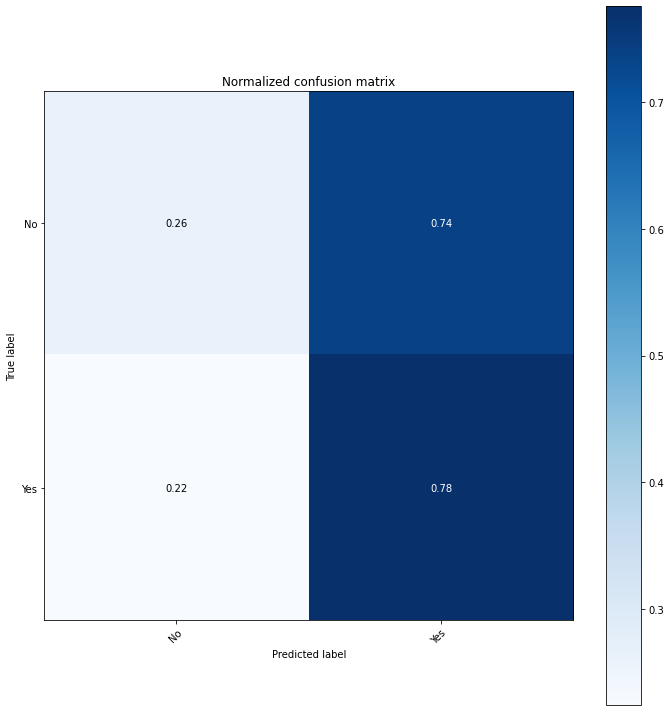

In [20]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.to(device)
def evaluate(model, eval_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            batch = {k:v.to(device) for k, v in batch.items()}
            output = model(batch)
            output = torch.sigmoid(output)
            output = (output > 0.5).float()
            y_true.extend(batch['Labels'].unsqueeze(-1).float().detach().cpu().numpy())
            y_pred.extend(output.detach().cpu().numpy())
    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 score:", f1_score(y_true, y_pred))
    print("Classification Report:", classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred, classes=['No', 'Yes'], normalize=True, title='Normalized confusion matrix')
    plt.show()

def evaluate_model(model, eval_loader, device):
    print("evaluating model....")
    y_true, y_pred = evaluate(model, eval_loader, device)
    print("plotting metrics...")
    plot_metrics(y_true, y_pred)

def predict(model, test_loader, device):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k:v.to(device) for k, v in batch.items()}
            output = model(batch)
            output = torch.sigmoid(output)
            output = (output > 0.5).float()
            y_pred.extend(output.detach().cpu().numpy())
    return y_pred

def predict_model(model, test_loader, device):
    y_pred = predict(model, test_loader, device)
    return y_pred

evaluate_model(model, eval_loader, device)


  0%|          | 0/25 [00:00<?, ?it/s]

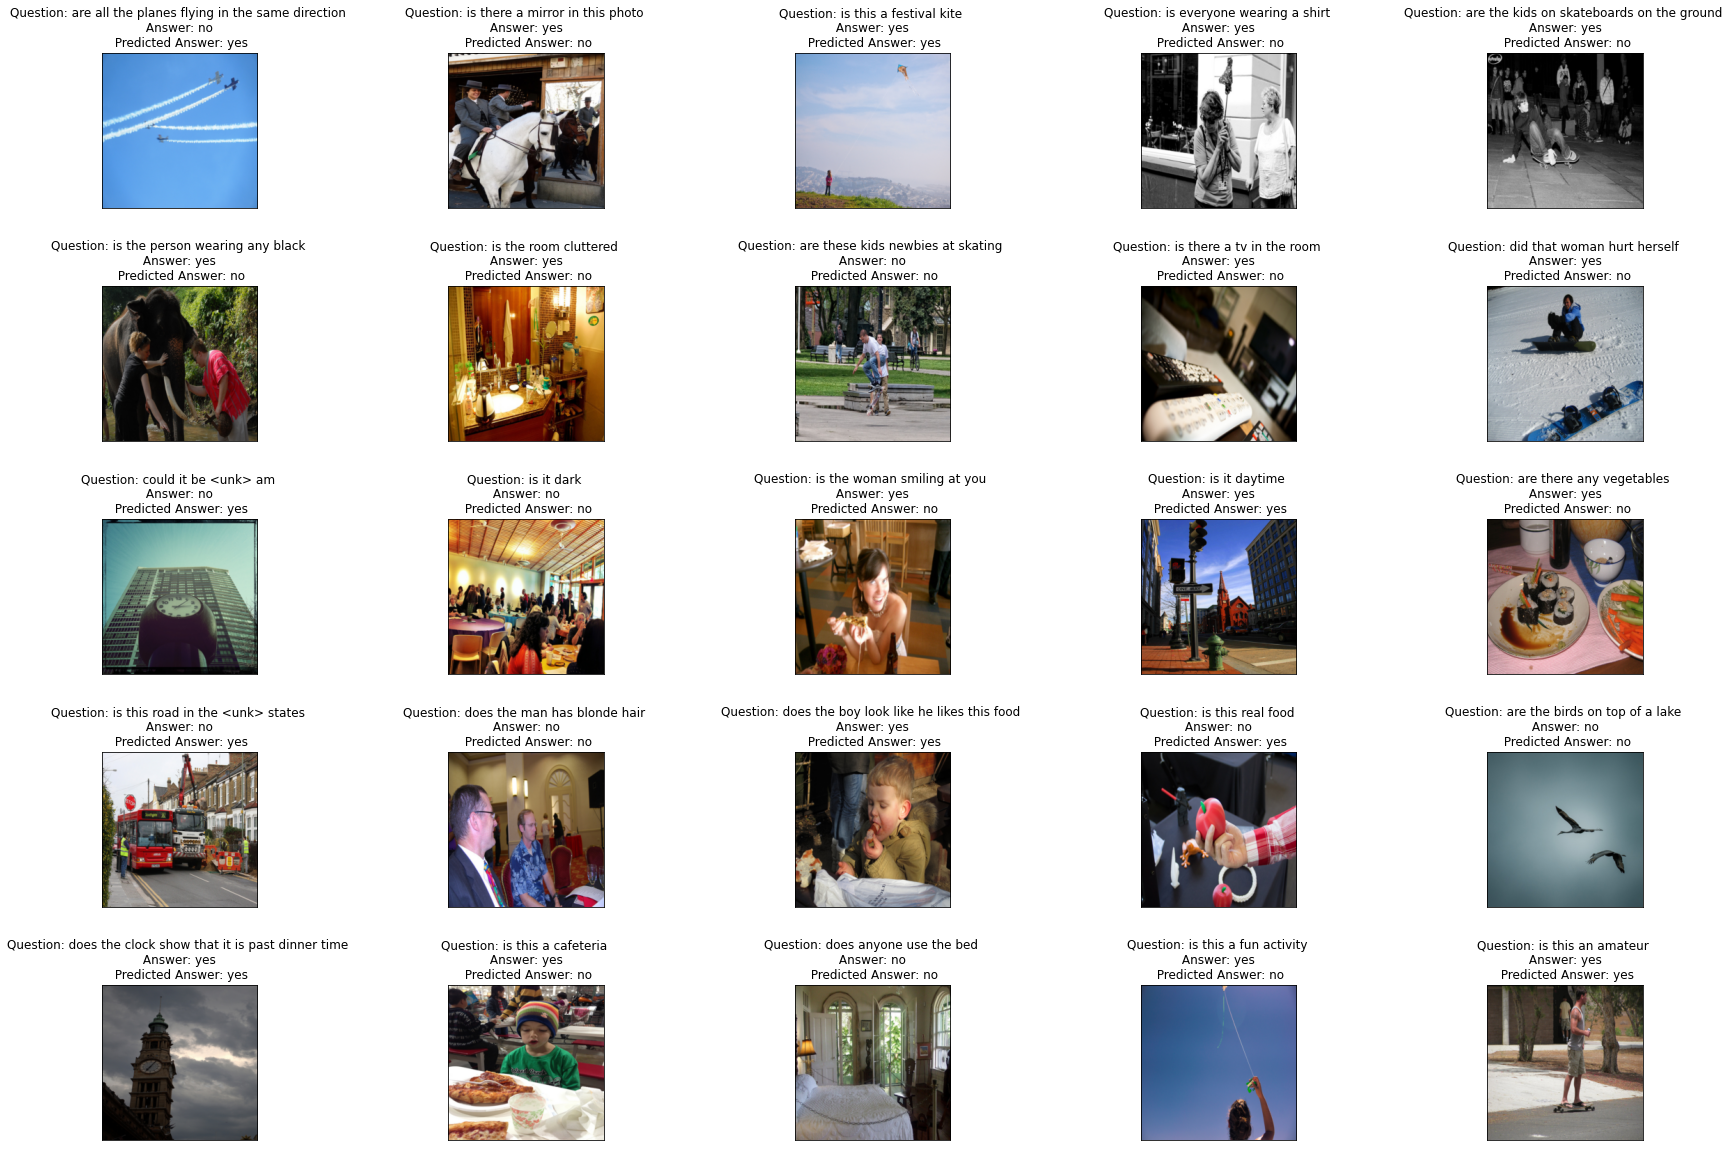

In [21]:
def predictions():
    images, quess, preds, labels = [], [], [], []
    for i in tqdm(range(25)):
        example = random.choice(train_dataset)
        ques = torch.cat([torch.tensor([BOS_IDX]), example[0], torch.tensor([EOS_IDX])], dim=0)
#         print(ques.unsqueeze(0).shape, example[1].unsqueeze(0).shape,torch.tensor(example[2]).unsqueeze(0).shape) 
        example = {
            "Questions":ques.unsqueeze(0),
            "images":example[1].unsqueeze(0),
            "Labels":torch.tensor(example[2]).unsqueeze(0)
        }
        example = {k:v.to(device) for k, v in example.items()}
        output = model(example)
        pred = torch.sigmoid(output)
        pred = (pred > 0.5).float()
        image = example['images'].cpu().numpy()
        ques = example['Questions'].cpu().numpy()
        pred = pred.cpu().numpy()
        label = example['Labels'].cpu().numpy()
        ques = " ".join([en_vocabulary.vocab.get_itos()[i] for i in ques[0] if i not in [BOS_IDX, EOS_IDX, PAD_IDX]])
#         print(ques)
        images.append(image)
        quess.append(ques)
        preds.append(pred)
        labels.append(label)

    fig, axs = plt.subplots(5, 5, figsize=(30, 20))
    fig.subplots_adjust(hspace=0.5)
    idx = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(images[idx].squeeze(0).transpose(1, 2, 0))
            axs[i, j].set_title(f"Question: {quess[idx]} \n Answer: {classes[int(labels[idx])]} \n Predicted Answer: {classes[int(preds[idx])]}")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            idx += 1
    plt.show()

predictions()